The first few cells will import some libraries and a script. For the most part this is identical to [xhlulu's Kaggle code.](https://www.kaggle.com/xhlulu/disaster-nlp-keras-bert-using-tfhub) Only difference is the first cell, which you only need to run if using google colab, and the importing of re and nltk in cell 3. 

In [1]:
# Use the following if you need the libraries. If working in google colab, you will need these lines.

# !pip install sentencepiece
# import nltk
# nltk.download('wordnet')

     |████████████████████████████████| 1.0MB 10.0MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


import tokenization

DONE


The following four cells are unchanged from the Kaggle code

In [0]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []


    for text in texts:
        text = tokenizer.tokenize(text)
           
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [0]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=2e-6), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
%%time
module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

CPU times: user 9.67 s, sys: 2.01 s, total: 11.7 s
Wall time: 13 s


In [0]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

This next cell is what separates this notebook from the Kaggle code. The function used to generated neighborhoods is defined. A small lemmatization function is defined and used in the generator function in order to extract a keyword index. The basic BERT tokenizer in conjunction with some regex filtering is used to clean and tokenize the text, again to find the keyword index. Once the keyword index is found, the neighborhood is generated by finding how many tokens to the left and how many tokens to the right to use as the neighborhood. These tokens are joined together with spaces and returned as output.

In [0]:
def lemmatize(x):
  lemmatizer = WordNetLemmatizer()
  return lemmatizer.lemmatize(lemmatizer.lemmatize(x,pos='v'))

kwds = 'blackout duke dukeenergy electric electricity fpl outage power'.split()
basic_tok = tokenization.BasicTokenizer()

def neighborhood_generator(text,kwd):
    parse_seq = r'[-_+<=>\[\]{}`&;\/()#!@,.\n?]|\x80|\:\/\/.*$'
    split_tokens = text.lower().split()
    stop_words = set(stopwords.words('english'))
    kwd_idx = 0

    def tok_process(tok): #remove special chars, apply basic BERT tokenizer, lemmatize, and remove stop words
        parse_tok = re.sub(parse_seq, ' ', tok)
        tok_tokens = basic_tok.tokenize(parse_tok) #tokens of the token!
        tok_lemmatized_tokens = [lemmatize(tok_tok) for tok_tok in tok_tokens]
        # tok_lemmatized_tokens = [tok_tok for tok_tok in tok_lemmatized_tokens if tok_tok not in stop_words]
        return tok_lemmatized_tokens

    if kwd in split_tokens: #see if we can get away without going through the text processing
        kwd_idx = [idx for idx in range(len(split_tokens)) if split_tokens[idx]==kwd][0]
    else:
        for idx in range(len(split_tokens)):
            tok = split_tokens[idx]
            tok_lemmatized_tokens = tok_process(tok)
            if kwd in tok_lemmatized_tokens:
                kwd_idx = idx
                break

    neighborhood_radius = 3
    before_kwd = split_tokens[:kwd_idx]
    after_kwd = split_tokens[kwd_idx+1:]

    before_idx = [idx for idx in range(kwd_idx)][::-1]
    after_idx = [idx for idx in range(kwd_idx+1,len(split_tokens))]
    start_tok_idx = 0 #if search extends beyond startin index, use the first token
    end_tok_idx = len(split_tokens) #if search extends beyond last index, use the last index
    before_sig_toks = 0
    after_sig_toks = 0

    for idx in before_idx:
        tok = split_tokens[idx]
        tok_lemmatized_tokens = tok_process(tok)
        if len(tok_lemmatized_tokens) > 0: # significant token
            before_sig_toks += 1
            if before_sig_toks == neighborhood_radius:
                start_tok_idx = idx
                break
    
    for idx in after_idx:
        tok = split_tokens[idx]
        tok_lemmatized_tokens = tok_process(tok)
        if len(tok_lemmatized_tokens) > 0:
            after_sig_toks += 1
            if after_sig_toks == neighborhood_radius:
                end_tok_idx = idx
                break
                
    neighborhood = split_tokens[start_tok_idx:end_tok_idx+1]
    neighborhood = ' '.join(neighborhood)
    
    return neighborhood

Iterate through all the tweets to generate the neighborhoods.

In [0]:
town = pd.DataFrame(columns=['text']) # a town is a collection of neighborhoods
neighborhood_vals = []

data = pd.read_csv('irma_power_tweets.csv')

for idx in data.index:
  row = data.iloc[idx]
  text = row.text
  kwd = row.kwd
  new_row = neighborhood_generator(text,kwd)
  neighborhood_vals.append(new_row)
town.text = neighborhood_vals
town['original_twt'] = data.text
town = town[['original_twt', 'text']]

from sklearn.model_selection import train_test_split
train, test, train_labels, test_labels = train_test_split(town.text, data.topic_related,
                                                          test_size=0.2,
                                                          random_state=42)

train_input = bert_encode(train, tokenizer, max_len=160)
test_input = bert_encode(test, tokenizer, max_len=160)

The next three cells are unchanged from the Kaggle code. These blocks build the model and predict the outputs for the data.

In [18]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [19]:
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

Epoch 1/3
94/94 [==============================] - 947s 10s/step - loss: 0.3609 - accuracy: 0.8203 - val_loss: 0.2471 - val_accuracy: 0.9200
Epoch 2/3
94/94 [==============================] - 942s 10s/step - loss: 0.1991 - accuracy: 0.9332 - val_loss: 0.2080 - val_accuracy: 0.9227
Epoch 3/3
94/94 [==============================] - 910s 10s/step - loss: 0.1244 - accuracy: 0.9639 - val_loss: 0.2133 - val_accuracy: 0.9253


In [0]:
test_pred = model.predict(test_input)
train_pred = model.predict(train_input)

After producing outputs, we're interested in seeing how well the model has done. So the following block defines a scoring function to output some metrics for both the training and test sets. Then a function for drawing a color map is defined.

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import itertools
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [10,10]


def scoring(Ytrain, Ytrain_pred, Ytest, Ypred):
    

    acc_train = accuracy_score(Ytrain, Ytrain_pred)
    prec_train = precision_score(Ytrain, Ytrain_pred)
    rec_train = recall_score(Ytrain, Ytrain_pred)
    f1_train = f1_score(Ytrain, Ytrain_pred)
    
    acc = accuracy_score(Ytest, Ypred)
    prec = precision_score(Ytest, Ypred)
    rec = recall_score(Ytest, Ypred)
    f1 = f1_score(Ytest, Ypred)

    scores = {'accuracy': acc,
              'precision': prec,
             'recall': rec,
             'f1 score': f1}

    scores_train = {'accuracy': acc_train,
              'precision': prec_train,
             'recall': rec_train,
             'f1 score': f1_train}

    print('Ytrain vs Ytrain_pred')
    for metric in scores_train.keys():
        print(f'{metric}: {scores_train[metric]:.2f}')
    
    print('\nYtest vs Ypred')
    for metric in scores.keys():
        print(f'{metric}: {scores[metric]:.2f}')
        


def plot_confusion_matrix(cm, labels: list, normalize=False, title='Confusion Matrix', cmap=plt.cm.Oranges):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title,size=24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, size=14)
    plt.yticks(tick_marks, labels, size=14)
    
    fmt = '.2f' if normalize else 'd' # format of decimal precision to display
    thresh = cm.max()/2 # threshold to change color of text depending on color of cell
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): # realistically, cm.shape[0] = cm.shape[1] = len(labels)
        plt.text(j, i, format(cm[i,j], fmt), fontsize=20, # i,j rev bc of diff btwn matrix and list of lists indexing
                 horizontalalignment='center',
                 color='white' if cm[i,j] > thresh else 'black') # if the cell color is too dark, make the text white
    plt.grid(False)
    plt.tight_layout()
    plt.ylabel('True label', size=16)
    plt.xlabel('Predicted label', size=16)

Now let's see the results.

Ytrain vs Ytrain_pred
accuracy: 0.97
precision: 0.97
recall: 0.99
f1 score: 0.98

Ytest vs Ypred
accuracy: 0.94
precision: 0.94
recall: 0.98
f1 score: 0.96


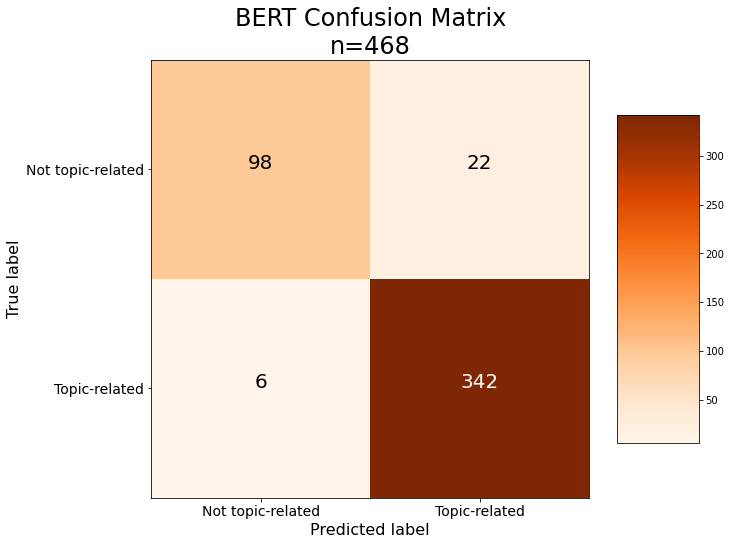

In [22]:
round_train_pred = np.round(train_pred)
round_test_pred = np.round(test_pred)
scoring(train_labels, round_train_pred, test_labels, round_test_pred)
cm = confusion_matrix(test_labels, round_test_pred)
cm_labels = ['Not topic-related', 'Topic-related']
plot_confusion_matrix(cm, cm_labels, normalize=False,title=f'BERT Confusion Matrix\nn={len(test_labels)}')